In [ ]:

from io import open
import glob
import os
import string
#import torch
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np 


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


1006897 55216 73068 206436


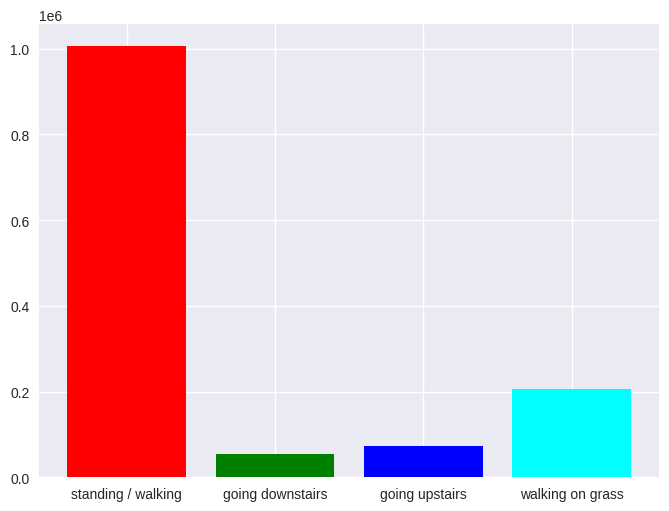

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/Interpolated_Combined/Interpolated_combined.csv')
walking_full = df[df.label==0].count()[0]
downstairs_full = df[df.label==1].count()[0]
upstairs_full = df[df.label==2].count()[0]
grass_full = df[df.label==3].count()[0]
print(walking_full, downstairs_full,upstairs_full, grass_full)
text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
label = [walking_full, downstairs_full,upstairs_full, grass_full]
color=[ 'red', 'green', 'blue', 'cyan']
plt.style.use('seaborn')
plt.figure(figsize=(8,6),dpi=100)
for bar in range(0,4):
    plt.bar(text[bar],label[bar], color=color[bar])


In [ ]:
# Data partition into x_train and y_train. Remove label and time from data
y_train = df.label
x_train= df.drop('label', axis=1)
x_train= x_train.drop('time', axis=1)
y_train = torch.tensor(y_train)

#One hot encoding

y_train_cat=nn.functional.one_hot(y_train.long(),4).reshape(-1,4)
print(y_train_cat)
df_y = pd.DataFrame(y_train_cat, columns = ['l1','l2','l3','l4'])


tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]])


In [ ]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(x_train)
df_x_scale = scaler.transform(x_train)
df_x_scale = pd.DataFrame(df_x_scale, columns = ['ax','ay','az','gx','gy','gz'])
print(df_x_scale)
df_x_scale=df_x_scale.astype(np.float32)

               ax        ay        az        gx        gy        gz
0        0.620543  0.045290 -0.567099  0.000351 -0.018272  0.083457
1        0.682938  0.054657 -0.570337  0.001033 -0.001082  0.089309
2        0.736081  0.055088 -0.568419  0.007191 -0.022229  0.069323
3        0.676755  0.012346 -0.577995  0.005263 -0.044493  0.060374
4        0.627449  0.034983 -0.577198  0.002453 -0.015124  0.065937
...           ...       ...       ...       ...       ...       ...
1341612  0.251684  0.127635 -1.716335 -0.001023 -0.014647  0.089143
1341613  0.253931  0.128546 -1.719921 -0.000847 -0.016142  0.087803
1341614  0.253695  0.127799 -1.723325 -0.002069 -0.018029  0.089157
1341615  0.258522  0.127588 -1.722741 -0.001386 -0.016478  0.090215
1341616  0.254385  0.126340 -1.719718 -0.001427 -0.016218  0.087803

[1341617 rows x 6 columns]


In [ ]:
#Calculate weights of each class for weighted cross entropy loss
import math
total_samples = walking_full + downstairs_full + upstairs_full + grass_full
class_weights = [1-(walking_full/total_samples), 1-(downstairs_full/total_samples), 1-(upstairs_full/total_samples), 1-(grass_full/total_samples)]
print(class_weights)
#[0.24948998111979792, 0.9588436938410888, 0.9455373627495776, 0.8461289622895357]
#Define the loss function
#criterion = nn.CrossEntropyLoss(weight = class_weights)

[0.24948998111979792, 0.9588436938410888, 0.9455373627495776, 0.8461289622895357]


In [ ]:
# Window size

def define_windows(df_x, df_y, windowsize=120):
  window_x=[]
  window_y=[]
  for i in range(0, len(df_x)-windowsize, windowsize+1):
    window_x.append([df_x.values[i:i+windowsize]])
    window_y.append([df_y.values[i:i+windowsize]])
    #window_y.append([df_y[['l1','l2','l3','l4']].values[i:i+windowsize]])
  window_x=np.array(window_x).reshape(-1,windowsize,6)
  window_y=np.array(window_y).reshape(-1,windowsize,4)

  return window_x, window_y
wsize = 40
x_window, y_window = define_windows(df_x_scale, df_y, wsize)
print(x_window.shape, y_window.shape)

(32722, 40, 6) (32722, 40, 4)


In [ ]:
#split the data into training and testing
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_window, y_window, test_size=0.3,random_state=123)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,batch_size,seq_len):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.input_size = input_size
        self.batch_size = 0
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(2*hidden_size,hidden_size,batch_first=True)
        self.layer_dim = 1
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)
        #self.bn1 = nn.LayerNorm()
        #self.g = nn.Linear(input_size + hidden_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64,output_size)
        self.fc = nn.Linear(hidden_size,output_size)
        self.relu = nn.ReLU()
        #self.softmax = nn.Softmax()
        #self.dropout1 = nn.Dropout(0.2)
        #self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, input,hidden):
        # N = input.size
        # L = input.shape[1]
        # h_in = input.shape[2]
        #print("hi")
        #hidden = self.initHidden()
        #self.batch_size = input.shape[0]
        batch_size = input.shape[0]
        #batch_size = self.batch_size
        hidden_0,cellState_0 = self.bilstm(input,hidden)
        #hidden_0 = self.dropout1(hidden_0)
        hidden = self.initHidden1(batch_size)
        #cell = self.initCell()
        #hidden_0_d = self.dropout1(hidden_0)
        #hidden_0_d_n = nn.LayerNorm(hidden_0_d.tolist())
        hidden_1,cellState_1 = self.lstm(hidden_0.float(),hidden)
        #hidden_1 = self.dropout2(hidden_1)
        #hidden_1_d = self.dropout2(hidden_1)
        #hidden_1_d_n = nn.LayerNorm(hidden_1_d.tolist())
        data = self.relu(self.fc1(hidden_1.float()))
        output = self.relu(self.fc2(data))
        #data = data.contiguous()
        #output = self.softmax(self.fc2(data))
        return output

    def initHidden(self,batch_size):
        
        return ((torch.zeros(2, batch_size,self.hidden_size)),(torch.zeros(2, batch_size,self.hidden_size)))
    def initHidden1(self,batch_size):
        return ((torch.zeros(1, batch_size,self.hidden_size)),(torch.zeros(1, batch_size,self.hidden_size)))
    
    
    # def initCell(self):
    #      return (torch.zeros(1, self.hidden_size))



In [ ]:
hidden_size = 128
batch_size = 512
seq_len = 40
output_size = 4
input_size = 6
#/content/gdrive/MyDrive/nnmodels/bi_lstm_model_fc2.pt
model= LSTMModel(input_size,hidden_size,output_size,batch_size,seq_len)
#bi_lstm_model = LSTMModel1(1, 128, 6, 512)
#hidden = bi_lstm_model.initHidden()

#Optimizer, criterion, parameters


In [ ]:
import csv
model_save_name = 'bi_lstm_model_fc2.pt'
path = F"/content/gdrive/MyDrive/nnmodels/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
pip install pytorch-model-summary

In [ ]:
from pytorch_model_summary import summary

summary(bi_lstm_model_h256_dropout_2_1_120_same_w,torch.zeros(512,40,6),((torch.zeros(2, batch_size,hidden_size)),(torch.zeros(2, batch_size,hidden_size))),show_input=True)

In [ ]:
from torchsummary import summary
#summary(bi_lstm_model_h256_dropout_2_1_120_same_w,torch.zeros(512,40,6),torch.zeros(2,512,258))

In [ ]:
pip install torch-summary

In [ ]:
def trainmodel(model,x_data,y_data,optimizer,criterion):
  model.float()
  #forward pass
  hidden = model.initHidden(x_data.shape[0]) 
  model.zero_grad()

  #
  
  summary(model,x_data,hidden)
  return
  output = model(x_data,hidden)

  #loss and backprop
  optimizer.zero_grad()
  #print(y_data.shape)
  #print(output.shape)
  y_data = y_data.contiguous()
  y_data = y_data.view(-1, y_data.shape[2])
  output = output.contiguous()
  output = output.view(-1,output.shape[2])
  #print(y_data.shape)
  #print(output.shape)
  loss = criterion(output,y_data)
  #print(loss.shape)
  loss.sum().backward()
  #print(loss)
  optimizer.step()
  
  #print(loss.item())
  return loss.sum().item()
 # print(output.shape)


In [ ]:
#learning_rate = 0.005
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights),reduction='none')
#optimizer = torch.optim.Adam(bi_lstm_model_fc2_lrdecay.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)



In [ ]:
import csv
model_save_name = 'bi_lstm_model_h256_dropout_2_1_120_same_w.pt'
path = F"/content/gdrive/MyDrive/nnmodels/{model_save_name}"

fields=['epoch','epoch_loss']
with open('/content/gdrive/MyDrive/nnmodels/bi_lstm_model_h256_dropout_2_1_120_same_w.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = fields)
    writer.writeheader()

In [ ]:
fields=['epoch','epoch_loss']

In [ ]:
import torch.optim.lr_scheduler as scheduler
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = scheduler.StepLR(optimizer, step_size=75, gamma=0.5)

In [ ]:

#total_samples
import math

no_of_batches = math.ceil(x_train.shape[0]/batch_size)
epochs = 300
runtime_loss =[]
#print(no_of_batches)
loss_epochs = []
epoch_number = []
for epoch in range(epochs):
  index = 0
  batch_loss = 0
  print("epoch number: ",epoch)
  for batch in range(no_of_batches):
    print("batch number: ", batch)
    if batch!= no_of_batches-1:
      x_input_data = x_train[index:512+index]
      y_input_data = y_train[index:512+index]
      index = index+512
      #print(x_input_data.shape)
      
      # trainmodel(bi_lstm_model,x_input_data,y_input_data)
    elif batch == no_of_batches-1:
      x_input_data = x_train[index:]
      y_input_data = y_train[index:]

    y_input_data  = y_input_data.astype(np.float)
    x_input_data=torch.from_numpy(x_input_data)
    #x_input_data = x_input_data.float()
    y_input_data = torch.from_numpy(y_input_data)
    loss = trainmodel(model,x_input_data,y_input_data,optimizer,criterion)
    break
    print("batch loss: ",loss)
    batch_loss = batch_loss+loss
  break
  print("epoch: ",epoch, " loss: ",batch_loss)
  epoch_number.append(epoch)
  loss_epochs.append(batch_loss)
  if (epoch+1)%10 == 0:
    print(epoch+1, " these many epochs done")
    torch.save(bi_lstm_model_h256_dropout_2_1_120_same_w.state_dict(), path)
    with open('/content/gdrive/MyDrive/nnmodels/bi_lstm_model_h256_dropout_2_1_120_same_w.csv', 'a') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames = fields)
      for ep,ele in zip(epoch_number,loss_epochs):
        writer.writerows([{'epoch':ep,'epoch_loss':ele}])
    epoch_number=[]
    loss_epochs=[]
  #if (epoch+1)%100 == 0:
  lr_scheduler.step()
  runtime_loss.append(batch_loss)
  # if (epoch+1)%10 == 0:
  #   print(epochs+1, " these many epochs done")
  #   torch.save(bi_lstm_model_fc2.state_dict(), path)
  # loss_epochs.append(batch_loss)


epoch number:  0
batch number:  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 40, 256]             139,264
├─LSTM: 1-2                              [-1, 40, 128]             197,632
├─Linear: 1-3                            [-1, 40, 64]              8,256
├─ReLU: 1-4                              [-1, 40, 64]              --
├─Linear: 1-5                            [-1, 40, 4]               260
├─ReLU: 1-6                              [-1, 40, 4]               --
Total params: 345,412
Trainable params: 345,412
Non-trainable params: 0
Total mult-adds (M): 0.34
Input size (MB): 0.47
Forward/backward pass size (MB): 0.14
Params size (MB): 1.32
Estimated Total Size (MB): 1.92


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/nnmodels/bi_lstm_model_h256_dropout_2_1.csv')
loss_iter = df['epoch']
runtime_loss = df['epoch_loss']

NameError: ignored

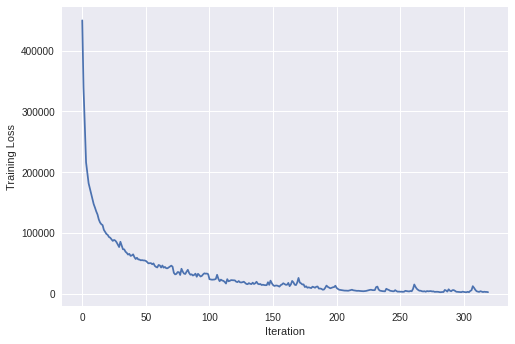

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# loss_iter = []
# for i in range(200):
#   loss_iter.append(i)

plt.figure()
plt.plot(loss_iter,runtime_loss)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
model_save_name = 'bi_lstm_model_h256_dropout_2_1_cw.pt'
path = F"/content/gdrive/My Drive/nnmodels/{model_save_name}"
bi_lstm_model_h256_dropout_2_1_cw.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
import csv
#for_example = [1, 2, 3, 4, 5, 6]
with open('/content/gdrive/MyDrive/nnmodels/bi_lstm_model_dropout_2_1.csv', 'w', newline='') as csv_1:
  csv_out = csv.writer(csv_1)
  csv_out.writerows([loss_epochs[index]] for index in range(0, len(loss_epochs)))


In [ ]:
print(x_val.shape)
print(x_val.shape[0]/512)
print(512*19)
test_b = x_val.shape[0]//512
print(test_b)

(3327, 120, 6)
6.498046875
9728
6


In [ ]:
# def evaluation(model):
#   confusion = torch.zeros(n_categories, n_categories)

# Just return an output given a line
def evaluate(model,x_val):
    hidden = model.initHidden(x_val.shape[0])
    output = model(x_val, hidden)

    return output

In [ ]:
index = 0
count = 0
prediction_list = []
ground_list = []
for bat in range(test_b-1):
  
  x_data = x_val[index:index+512]
  #x_data = x_val
  y_data = y_val[index:index+512]
  # if bat == test_b-1:
  #   x_data = x_val[index:]
  #   y_data = y_val[index:]
  x_test_data=torch.from_numpy(x_data)
  y_data  = y_data.astype(np.float)
  y_test_data = torch.from_numpy(y_data)
  y_predicted_data = evaluate(bi_lstm_model_h256_dropout_2_1_cw,x_test_data)
  y_predicted_data = y_predicted_data.contiguous()
  y_predicted_data = y_predicted_data.view(-1, y_predicted_data.shape[2])
  y_test_data = y_test_data.contiguous()
  y_test_data = y_test_data.view(-1,y_test_data.shape[2])
  pred = torch.argmax(y_predicted_data,dim=1)
  #print(pred)
  pred_list = pred.tolist()
  orig = torch.argmax(y_test_data,dim=1)
  orig_list = orig.tolist()
  prediction_list.extend(pred_list)
  ground_list.extend(orig_list)
  #print(y_test_data.shape)
  count = count +torch.sum(pred==orig)
  print(count)


  # extracted_values = a[mask]
  # print(extracted_values)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


tensor(57183)
tensor(114544)
tensor(171764)
tensor(229007)
tensor(286206)


In [ ]:
286206/307200

0.93166015625

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(prediction_list, ground_list))

NameError: ignored